In [1]:
#from hepmc import *
from hepmc.core.densities.qcd import ee_qq_ng, export_hepmc
from hepmc.core.densities.sarge import Sarge
from hepmc.core.phase_space.rambo import RamboOnDiet
from hepmc.core.phase_space.logit import LogitDensity
from scipy.special import logit, expit
from hepmc.core.phase_space.mapping import MappedDensity
from hepmc.core.markov.metropolis import DefaultMetropolis
from hepmc.core.markov.base import MixingMarkovUpdate
from hepmc.core.markov.metropolis_adaptive import AdaptiveMetropolisUpdate
from hepmc.core.proposals import Gaussian
from hepmc import surrogate
from hepmc.core import densities
from hepmc.core.hamiltonian.hmc import HamiltonianUpdate
from hepmc.core.hamiltonian.spherical_hmc import StaticSphericalHMC
from hepmc.core.hamiltonian.wall_hmc import WallHMC
from hepmc.core.sampling import Sample
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
eeqqg = ee_qq_ng(1, 100., 5., .3)

In [3]:
rambo_mapping = RamboOnDiet(100., 3)
mapped = MappedDensity(eeqqg, rambo_mapping)
mapped_logit = LogitDensity(mapped)

In [ ]:
# Surrogate HMC without spherical augmentation
start = np.random.random(5)
print('start:', start)
print('pot:', mapped.pot(start))

sampler = HamiltonianUpdate(mapped, densities.gaussian.Gaussian(5, 1.), 30, .001)
%time hmc_sample = sampler.sample(15000, start)

In [ ]:
mapped_hmc_sample = Sample(data=rambo_mapping.map(hmc_sample.data[5000:]), weights=np.full(10000, 1/10000))
export_hepmc(100., mapped_hmc_sample, "../samples/qcd/2-3/hmc.hepmc")

In [ ]:
# hmc without spherical mixed with sarge
sarge = Sarge(2, 3, 100.)
importance = DefaultMetropolis(eeqqg, proposal=sarge)  # using sarge, full momentum sample space
local = HamiltonianUpdate(mapped, densities.gaussian.Gaussian(5, 1.), 30, .001)
update = MixingMarkovUpdate(5, [importance, local], weights=[.1, .9], target=mapped,
                            out_maps={0: rambo_mapping.map_inverse},
                            in_maps={0: rambo_mapping.map}) # rambo sample space, important to set target explicitly
start = update.sample(5000, np.random.rand(5)).data[-1] # warmup
%time mc3_sample = update.sample(10000, start)

In [ ]:
mapped_mc3_sample = Sample(data=rambo_mapping.map(mc3_sample.data), weights=mc3_sample.weights)
export_hepmc(100., mapped_mc3_sample, "../samples/qcd/2-3/hmc_sarge.hepmc")

In [4]:
nodes = 300
nlearn = 100000

xvals = np.random.random((nlearn, 5))
fvals = mapped.pdf(xvals)

# surrogate
basis = surrogate.extreme_learning.GaussianBasis(5)
#log_vals = -np.ma.log(fvals)
#xvals = xvals[~log_vals.mask]
#log_vals = log_vals[~log_vals.mask]
# train
%time params = basis.extreme_learning_train(xvals, fvals, nodes)

# surrogate
def surrogate_fn(xs):
    return basis.eval(*params, xs)[0]

# surrogate gradient
def surrogate_gradient(xs):
    return basis.eval_gradient(*params, xs)
#mapped.pot_gradient = surrogate_gradient
#mapped.pdf_gradient = surrogate_gradient

def pot_gradient(xs):
    pdf = mapped.pdf(xs)
    if pdf == 0:
        return np.full(5, np.inf)
    
    return -surrogate_gradient(xs) / pdf

mapped.pot_gradient = pot_gradient

CPU times: user 23.2 s, sys: 8.03 s, total: 31.2 s
Wall time: 14.6 s


In [ ]:
#start = np.array([0.30527385, 0.59699739, 0.51985594, 0.57366659, 0.51096818])
start = np.random.random(5)
sampler = StaticSphericalHMC(mapped, .005, .005, 30, 30)
%time hmc_sample = sampler.sample(15000, start)

In [ ]:
print('estimated ESS:', util.effective_sample_size(hmc_sample, hmc_sample.mean, hmc_sample.variance))

In [ ]:
mapped_hmc_sample = Sample(data=rambo_mapping.map(hmc_sample.data[5000:]), weights=hmc_sample.weights[5000:])
#mapped_hmc_sample = Sample(data=rambo_mapping.map(hmc_sample.data[5000:]), weights=np.full(10000, 1/10000))
export_hepmc(100., mapped_hmc_sample, "../samples/qcd/2-3/hmc.hepmc")

In [ ]:
# resample
resamp_idx = np.random.choice(100000, 100000, p=hmc_sample.weights[50000:]/hmc_sample.weights[50000:].sum())
hmc_resample = Sample(data=hmc_sample.data[50000:][resamp_idx], weights=np.full(100000, 1./100000))

In [ ]:
mapped_hmc_sample = Sample(data=rambo_mapping.map(hmc_resample.data), weights=hmc_resample.weights)
export_hepmc(100., mapped_hmc_sample, "../samples/qcd/2-3/hmc.hepmc")

In [ ]:
print(hmc_sample.weights.min())
print(hmc_sample.weights.max())
print(hmc_sample.weights.mean())

In [ ]:
# hmc mixed with sarge
sarge = Sarge(2, 3, 100.)
importance = DefaultMetropolis(eeqqg, proposal=sarge)  # using sarge, full momentum sample space
local = StaticSphericalHMC(mapped, .1, .1, 20, 20)  # using rambo, rambo sample space
update = MixingMarkovUpdate(5, [importance, local], weights=[.1, .9], target=mapped,
                            out_maps={0: rambo_mapping.map_inverse},
                            in_maps={0: rambo_mapping.map}) # rambo sample space, important to set target explicitly
start = update.sample(5000, np.random.rand(5)).data[-1] # warmup
%time mc3_sample = update.sample(10000, start)

In [ ]:
mapped_mc3_sample = Sample(data=rambo_mapping.map(mc3_sample.data), weights=mc3_sample.weights)
export_hepmc(100., mapped_mc3_sample, "../samples/qcd/2-3/hmc_sarge.hepmc")

In [ ]:
np.partition(mc3_sample.weights, -100)[-100:]

In [ ]:
np.argpartition(mc3_sample.weights, -100)[-100:]

In [ ]:
# resample
resamp_idx = np.random.choice(100000, 100000, p=mc3_sample.weights)
mc3_resample = MarkovSample(data=mc3_sample.data[resamp_idx], weights=np.full(100000, 1./100000))

In [ ]:
mapped_mc3_sample = MarkovSample(data=rambo_mapping.map(mc3_resample.data), weights=mc3_resample.weights)
densities.export_hepmc(100., mapped_mc3_sample, "../samples/qcd/2-3/hmc_sarge.hepmc")

In [ ]:
mc3_sample_thinned = MarkovSample(data=mc3_sample.data[::10], weights=mc3_sample.weights[::10])
mc3_sample_thinned.weights /= mc3_sample_thinned.weights.sum()
# resample
resamp_idx = np.random.choice(10000, 10000, p=mc3_sample_thinned.weights)
mc3_resample = MarkovSample(data=mc3_sample_thinned.data[resamp_idx], weights=np.full(10000, 1./10000))

In [ ]:
mapped_mc3_sample = MarkovSample(data=rambo_mapping.map(mc3_resample.data), weights=mc3_resample.weights)
densities.export_hepmc(100., mapped_mc3_sample, "../samples/qcd/2-3/hmc_sarge.hepmc")

In [ ]:
# Metropolis with Rambo mapping
met = DefaultMetropolis(mapped, Gaussian(5, .01))
start = met.sample(5000, np.random.rand(5)).data[-1] # warmup
%time met_sample = met.sample(10000, start)

In [ ]:
mapped_met_sample = Sample(data=rambo_mapping.map(met_sample.data), weights=np.full(10000, 1/10000))
export_hepmc(100., mapped_met_sample, "../samples/qcd/2-3/metropolis.hepmc")

In [33]:
# Wall HMC
#start = np.random.random(5)
#start = np.array([.96, .4, .6, .5, .5])
start = np.array([0.27038678, 0.19230907, 0.08674884, 0.76285181, 0.61187865])
print('start:', start)
print('pdf:', mapped.pdf(start))
print('pot:', mapped.pot(start))
print('pot_grad:', mapped.pot_gradient(start))
sampler = WallHMC(mapped, .1, .1, 10, 10)
#sampler.p_dist.cov = np.diag(5*[.01])
start = sampler.sample(5000, start).data[-1] # warmup
print('start:', start)
%time wallhmc_sample = sampler.sample(50000, start)

start: [0.27038678 0.19230907 0.08674884 0.76285181 0.61187865]
pdf: [3272.80076587]
pot: [10.7473158]
pot_grad: [[ 0.04639553 -0.08069323 -0.0522924   0.01943172 -0.02927583]]
Event 1	(batch acceptance rate: 0.000000)
Event 2	(batch acceptance rate: 0.500000)	max sequence length: 2
Event 3	(batch acceptance rate: 0.666667)	max sequence length: 2
Event 4	(batch acceptance rate: 0.750000)	max sequence length: 2
Event 5	(batch acceptance rate: 0.800000)	max sequence length: 2
Event 6	(batch acceptance rate: 0.833333)	max sequence length: 2
Event 7	(batch acceptance rate: 0.857143)	max sequence length: 2
Event 8	(batch acceptance rate: 0.875000)	max sequence length: 2
Event 9	(batch acceptance rate: 0.888889)	max sequence length: 2
Event 10	(batch acceptance rate: 0.900000)	max sequence length: 2
Event 20	(batch acceptance rate: 0.950000)	max sequence length: 2
Event 30	(batch acceptance rate: 0.966667)	max sequence length: 2
Event 40	(batch acceptance rate: 0.975000)	max sequence length:

In [34]:
wallhmc_sample_df = pd.DataFrame(wallhmc_sample.data)

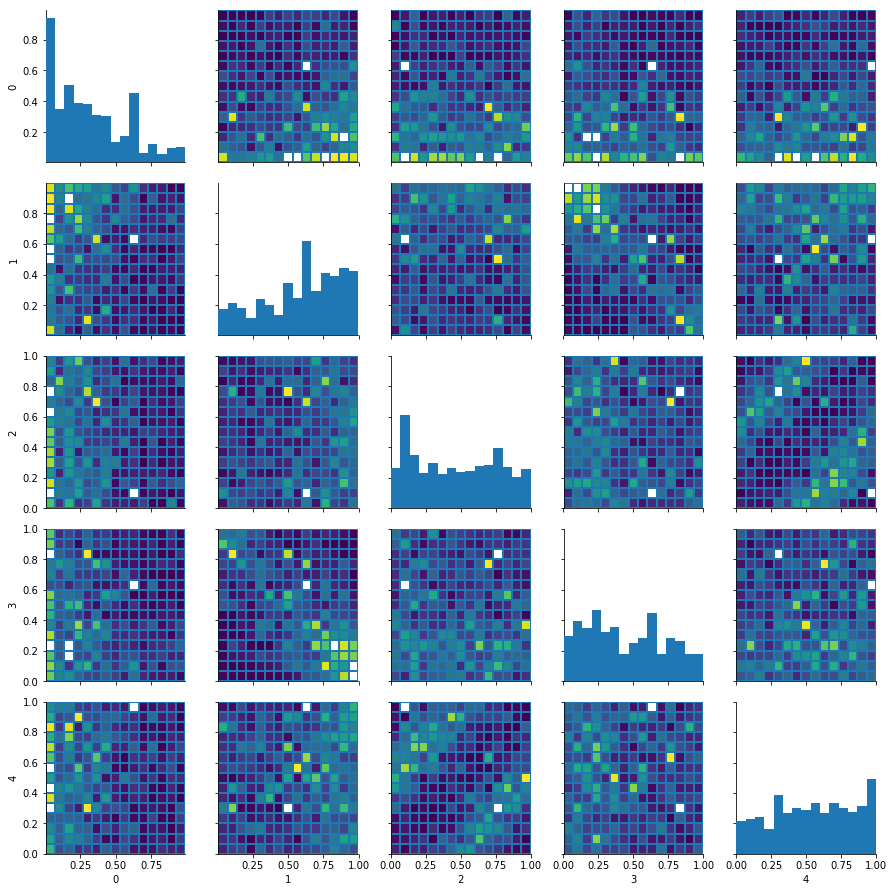

In [38]:
k = sns.PairGrid(wallhmc_sample_df)
k = k.map_diag(plt.hist, bins=15)
k = k.map_offdiag(plt.hist2d, bins=15, cmax=1000)

In [40]:
mapped_wallhmc_sample = Sample(data=rambo_mapping.map(wallhmc_sample.data), weights=np.full(50000, 1/50000))
export_hepmc(100., mapped_wallhmc_sample, "../samples/qcd/2-3/wallhmc.hepmc")